In [59]:
import pandas as pd
import numpy as np
import spacy
import matplotlib.pyplot as plt
import unicodedata
import string
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_predict
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from gensim.models import Word2Vec, KeyedVectors
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.svm import SVC
import seaborn as sns
import joblib
import re
import spacy
%matplotlib inline

In [2]:
# Load the spacy library for text cleaning
nlp = spacy.load('en_core_web_sm')

In [3]:
#Loading the dataset
df_resume = pd.read_csv('../data/UpdatedResumeDataSet.csv')

In [4]:
df_resume["Category"].unique()

array(['Data Science', 'HR', 'Advocate', 'Arts', 'Web Designing',
       'Mechanical Engineer', 'Sales', 'Health and fitness',
       'Civil Engineer', 'Java Developer', 'Business Analyst',
       'SAP Developer', 'Automation Testing', 'Electrical Engineering',
       'Operations Manager', 'Python Developer', 'DevOps Engineer',
       'Network Security Engineer', 'PMO', 'Database', 'Hadoop',
       'ETL Developer', 'DotNet Developer', 'Blockchain', 'Testing'],
      dtype=object)

In [5]:
df_resume.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 962 entries, 0 to 961
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  962 non-null    object
 1   Resume    962 non-null    object
dtypes: object(2)
memory usage: 15.2+ KB


In [6]:
df_resume.isnull().sum()

Category    0
Resume      0
dtype: int64

<AxesSubplot:xlabel='count', ylabel='Category'>

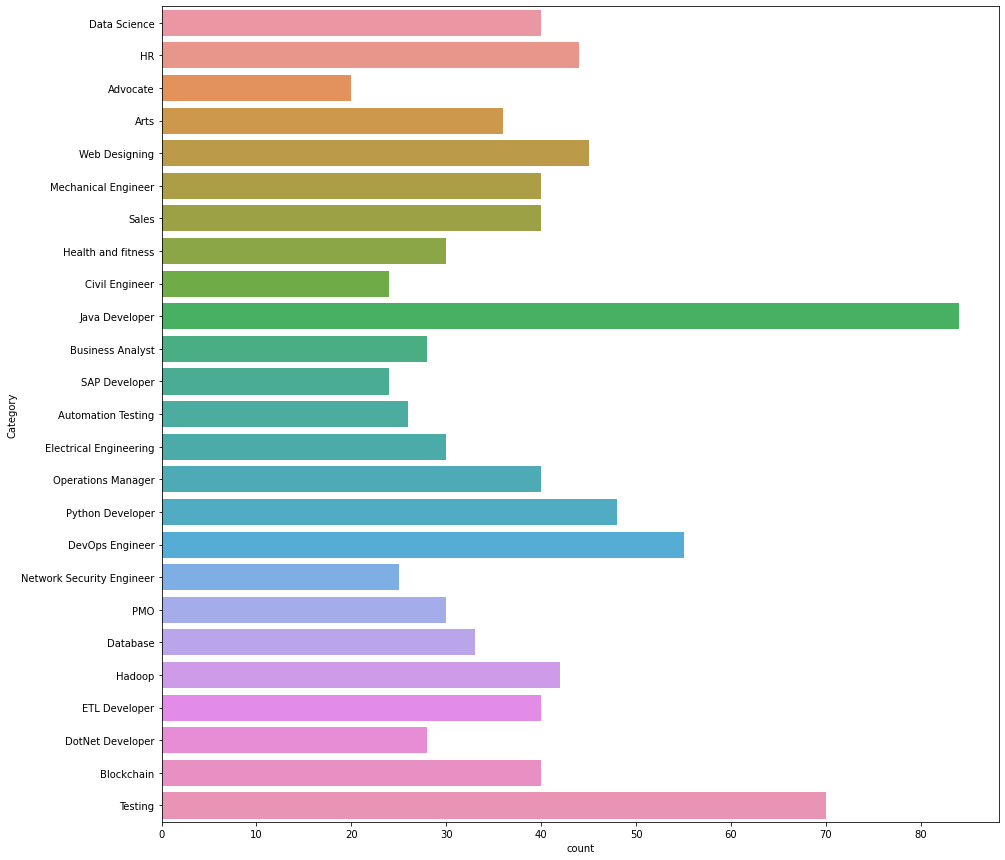

In [12]:
plt.figure(figsize=(15,15))
sns.countplot(y="Category", data=df_resume)

In [25]:
# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicode_to_ascii(s):
    all_letters = string.ascii_letters + " .,;'-"
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

# Remove Stop Words
def remove_stopwords(text):
    doc = nlp(text)
    return " ".join([token.text for token in doc if not token.is_stop])

In [31]:
def clean_text(text):
    #print(f'Text before Cleaning: {text}')
    # Text to lowercase
    text = text.lower()
    # Remove URL from text
    text = re.sub(r"http\S+", "", text)
    # Remove Numbers from text
    text = re.sub(r'\d+', '', text)
    # Convert the unicode string to plain ASCII
    text = unicode_to_ascii(text)
    # Remove Punctuations
    text = re.sub(r'[^\w\s]','', text) 
    #text = remove_punct(text)
    # Remove StopWords
    text = remove_stopwords(text)
    # Remove empty spaces
    text = text.strip()
    # \s+ to match all whitespaces
    # replace them using single space " "
    text = re.sub(r"\s+", " ", text)    
    #print(f'Text after Cleaning: {text}')
    return text

In [32]:
def preprocess_text(df):
    all_resume = list()
    print("Datapreprocessing Started!!!!")
    df["clean_resume"] = df.Resume.apply(lambda x: clean_text(x))
    resume = df.clean_resume.values.tolist()
    for res in resume:
    # Lemma the resume
        doc = nlp(res)
        tokens = [token.lemma_ for token in doc]
        # remove remaining tokens that are not alphabetic
        words = [word for word in tokens if word.isalpha()]
        # filter out stop words
        my_stopwords = ['amp','nt', '_', 'utckm']
        stop_words = set(nlp.Defaults.stop_words)
        words = [word for word in words if word not in stop_words and word not in my_stopwords]
        all_resume.append(words)
    print("Datapreprocessing Done!!!")

    return all_resume, df

In [33]:
resume_list, resumeDataSet = preprocess_text(df_resume)

Datapreprocessing Started!!!!
Datapreprocessing Done!!!


In [34]:
resumeDataSet

,Category,Resume,clean_resume
0,Data Science,Skills * Programming Languages: Python (pandas...,skills programming languages python pandas num...
1,Data Science,Education Details \r\nMay 2013 to May 2017 B.E...,education details uitrgpvdata scientist data s...
2,Data Science,"Areas of Interest Deep Learning, Control Syste...",areas interest deep learning control system de...
3,Data Science,Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...,skills r python sap hana tableau sap hana sql ...
4,Data Science,"Education Details \r\n MCA YMCAUST, Faridab...",education details mca ymcaust faridabad haryan...
...,...,...,...
957,Testing,Computer Skills: â¢ Proficient in MS office (...,computer skills proficient ms office word basi...
958,Testing,â Willingness to accept the challenges. â ...,willingness accept challenges positive thinkin...
959,Testing,"PERSONAL SKILLS â¢ Quick learner, â¢ Eagerne...",personal skills quick learner eagerness learn ...
960,Testing,COMPUTER SKILLS & SOFTWARE KNOWLEDGE MS-Power ...,computer skills software knowledge mspower poi...


In [46]:
column = ["Category"]
le = LabelEncoder()
for i in column:
    resumeDataSet[i] = le.fit_transform(resumeDataSet[i])

In [47]:
resumeDataSet

,Category,Resume,clean_resume
0,6,Skills * Programming Languages: Python (pandas...,skills programming languages python pandas num...
1,6,Education Details \r\nMay 2013 to May 2017 B.E...,education details uitrgpvdata scientist data s...
2,6,"Areas of Interest Deep Learning, Control Syste...",areas interest deep learning control system de...
3,6,Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...,skills r python sap hana tableau sap hana sql ...
4,6,"Education Details \r\n MCA YMCAUST, Faridab...",education details mca ymcaust faridabad haryan...
...,...,...,...
957,23,Computer Skills: â¢ Proficient in MS office (...,computer skills proficient ms office word basi...
958,23,â Willingness to accept the challenges. â ...,willingness accept challenges positive thinkin...
959,23,"PERSONAL SKILLS â¢ Quick learner, â¢ Eagerne...",personal skills quick learner eagerness learn ...
960,23,COMPUTER SKILLS & SOFTWARE KNOWLEDGE MS-Power ...,computer skills software knowledge mspower poi...


In [51]:
X = resumeDataSet["clean_resume"]
y = resumeDataSet["Category"]

In [52]:
# Use CountVectorizer to encode text into vectors
cv = CountVectorizer()
X = cv.fit_transform(X)
#X_test = cv.transform(X_test)

In [63]:
### BEGIN SOLUTION
ml_classifiers = {
    "Random Forest": RandomForestClassifier(min_samples_leaf=3),
    "SVC": SVC(C=0.5),
    "KNN": KNeighborsClassifier(n_neighbors=3),
}

In [64]:
skf = StratifiedKFold(n_splits=5, shuffle=True)


In [65]:
import time

results = []
accuracy = 0
for name, model in ml_classifiers.items():
    start_time = time.time()
    print(f'Training {model}')
    #model.fit(X_train, y_train)
    #prediction = model.predict(X_test)
    prediction = cross_val_predict(model, X, y, cv=skf)
    acc = (prediction==y).mean()*100
    total_time = time.time() - start_time
    print(f'Finished Training {model}')
    
    results.append({
        'ModelName': name,
        #'Train Accuracy': model.(X_train, y_train)*100,
        'Accuracy': acc,
        'F1-Score': metrics.f1_score(prediction, y, average='macro')*100,
        'Time': total_time})

    # conf_mat = confusion_matrix(y, prediction, labels=model.classes_)
    # disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=model.classes_)
    # disp.plot()

    if acc > accuracy:
        accuracy = acc
        best_model = model
        
results_ord = pd.DataFrame(results)

Training RandomForestClassifier(min_samples_leaf=3)
Finished Training RandomForestClassifier(min_samples_leaf=3)
Training SVC(C=0.5)
Finished Training SVC(C=0.5)
Training KNeighborsClassifier(n_neighbors=3)
Finished Training KNeighborsClassifier(n_neighbors=3)


In [66]:
results_ord

,ModelName,Accuracy,F1-Score,Time
0,Random Forest,98.856549,98.759521,3.331438
1,SVC,84.199584,84.551108,3.864357
2,KNN,96.777547,95.988513,0.192304


In [62]:
prediction

array([ 6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  6,  6,  6,  6, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,
       12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,
       12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,  0,
        0, 12,  0,  0,  0,  0,  0,  0,  0,  0,  0, 12,  0,  0,  0,  0,  0,
        0,  0,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24,
       24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24,
       24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 16, 16,
       16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
       16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
       16, 16, 16, 16, 22